Solve Cahn-Hilliard equation for alternating random sine flow.
Compute the $L^2$, $H^1$ etc. decays.

In [7]:
%pylab inline
import sys
import scipy.interpolate
import time
import matplotlib.animation
from IPython.display import HTML

# Matplotlib Defaults
rc('image', cmap='jet')

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/py_3_6_7/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
# Parameters
dt = 1/16                      # time step
N = 2**9                       # Fourier modes
D = 1e-3                       # Diffusivity
T = 50                         # number of periods
A = 1                          # shear amplitude
L = 1                          # domain size
K = 2*pi/L
gamma = 1 / (100 * K**2)     # Cahn number

solveeq = 'CH'                 # solve Cahn-Hilliard equation
#solveeq = 'AD'                 # solve advection-diffusion equation
#solveeq = 'AHD'                # solve advection-hyperdiffusion equation

saveframes = False             # don't save frames to save memory
savefigs = False

Text(0.5, 1.0, 'Shear Profile')

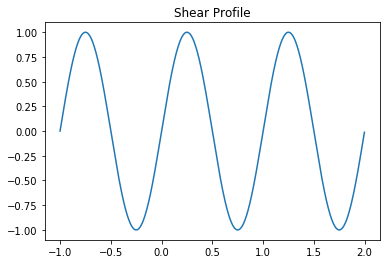

In [9]:
## Shear profile

# Sine shear
f = lambda x: A * sin(K*x)

(V, dx) = linspace( 0, 1, num=N, retstep=True, endpoint=False )
V3 = concatenate( (V-1, V, V+1) )
plot( V3, f(V3) )
title('Shear Profile')

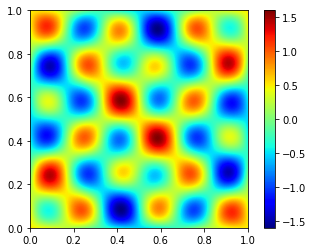

In [10]:
# Initial data

c0_fixed = lambda x, y: \
    sin(3*K * x) * sin(3*K * y) \
    + .5 * cos(K * x) * cos(K * y) \
    - .5 * sin(2*K * x) * sin(K * y)

c0 = c0_fixed
(xx, yy) = meshgrid( V, V )
imshow( c0(xx, yy), extent=[0, 1, 0, 1], interpolation='bilinear' )
colorbar()

In [11]:
k_range = arange(N)
k = diag( 1j*K* (k_range - N * (k_range > N/2) ) )
px_hat = array( ones([N,N] ) * matrix(k) )
px2_hat = px_hat**2

py_hat = array( matrix(k) * ones([N,N]) )
py2_hat = py_hat**2

# For N even we have to multipliy the N/2'th fourier modes by 0 for the first
# derivative. For the second derivative we don't have to do this. (Google fft
# differentiation for why).
if N % 2 == 0:
    px_hat = array( matrix(px_hat) * diag( k_range != N/2 ) )
    py_hat = array( diag( k_range != N/2 ) * matrix(py_hat) )
    
lap_hat = px2_hat + py2_hat
Lambda_hat = sqrt(-lap_hat)
Lambda_inv_hat = 1 / Lambda_hat  # this produces a divide-by-zero warning, of course
Lambda_inv_hat[0,0] = 0

lap = lambda f: ifft2( lap_hat * fft2(f) )
Lambda = lambda f: ifft2( Lambda_hat * fft2(f) )
LambdaInv = lambda f: ifft2( Lambda_inv_hat * fft2(f) )

free_energy = lambda f: \
    dint( (f**2 - 1)**2/4 + gamma/2*Lambda(f)**2 )

if solveeq == 'CH':
    CH_hat = ones_like(lap) + D*dt*lap_hat + D*gamma*dt*lap_hat**2
elif solveeq == 'AD':
    CH_hat = ones_like(lap) - D*dt*lap_hat
elif solveeq == 'AHD':
    CH_hat = ones_like(lap) + D*gamma*dt*lap_hat**2
else:
    print("error: unknown equation type")
    sys.exit(1)
CH_inv_hat = 1 / CH_hat

dint = lambda f: trapz( trapz(f, dx=dx), dx=dx )
norm2 = lambda f: dint( abs(f)**2 )

/anaconda3/envs/py_3_6_7/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/envs/py_3_6_7/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [12]:
start_time = time.process_time()

tt = arange( 0, T, step=dt )
max_iters = len(tt)
l2_lower_threshold = 1e-5

l2 = zeros( max_iters )
linf = zeros_like(l2)
h1 = zeros_like(l2)
hm1 = zeros_like(l2)
F = zeros_like(l2)

# Horizontal/vertical indicator.  Start at -1 to trigger immediate recalculation.
hv = -1

c = c0( xx, yy )
c = c / sqrt( norm2(c) )

if saveframes:
    csave = zeros( (max_iters, N, N) )
    csave[0, :] = c

l2[0] = sqrt( norm2( c ) )
h1[0] = sqrt( norm2( Lambda( c ) ) )
hm1[0] = sqrt( norm2( LambdaInv( c ) ) )
F[0] = free_energy( c )

pad_points = 4
Vpad = concatenate( ( V[-pad_points:]-1, V, V[:pad_points]+1) )
Npad = range(-pad_points, N + pad_points )

for n in range(1, max_iters):
    if solveeq == 'CH':
        RHS = dt*real( lap(D*c[:]**3) ) + c[:]
    elif solveeq == 'AD' or solveeq == 'AHD':
        RHS = c[:]
    else:
        print("error: unknown equation type")
        sys.exit(1)

    cn = real( ifft2( CH_inv_hat * fft2(RHS) ) )

    # Are we in a horizontal or vertical period?
    hvn = int(n*dt) % 2
    if hvn != hv:
        hv = hvn
        if n != 1:
            print( "t={t:.3f}, time elapsed: {T:.2f}s".format( 
                    t=n*dt, T=time.process_time() - start_time ) )
        # If there is a change in direction, generate a new phase.
        phase = L*random.random()
        # Define a new shear flow.
        if hvn == 0:
            def shear( x, y ):
                return (x + dt*f(y + phase))%L, y%L
        else:
            def shear( x, y ):
                return x%L, (y + dt*f(x + phase))%L
        # Recompute the dt-map for the new shear.
        (xx_adv, yy_adv) = shear( xx, yy )

    # Pad the array, using periodicity.
    cn_pad = pad( cn, pad_points, mode='wrap')
    # Create interpolating function.
    cn_spline = scipy.interpolate.RectBivariateSpline( 
        Vpad, Vpad, cn_pad.transpose())
    # Interpolate values from the advected grid.
    cn = cn_spline.ev(xx_adv, yy_adv)

    l2[n] = sqrt( norm2( cn ) )
    linf[n] = np.max( np.max( abs(cn), axis=0 ), axis=0 )
    h1[n] = sqrt( norm2( Lambda(cn) ) )
    hm1[n] = sqrt( norm2( LambdaInv(cn) ) )
    F[n] = free_energy( cn )

    c = cn
    
    if saveframes:
        csave[n,:] = c[:]

/anaconda3/envs/py_3_6_7/lib/python3.6/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


ValueError: First argument must be a complex or real sequence of single or double precision

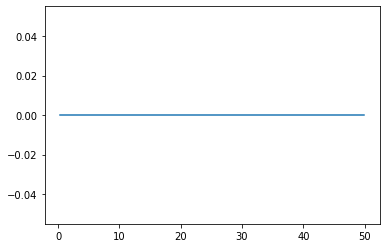

In [13]:
plot( tt[5:], F[5:] )

/anaconda3/envs/py_3_6_7/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/envs/py_3_6_7/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/py_3_6_7/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


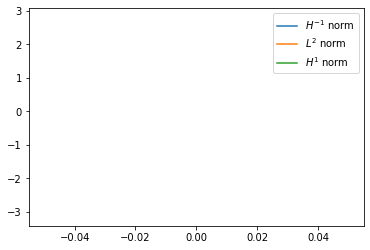

In [14]:
tt = linspace(0, T, num=max_iters, endpoint=False )
plot( tt, -log(hm1), label=r'$H^{-1}$ norm')
plot( tt, -log(l2), label=r'$L^2$ norm' )
plot( tt, -log(h1), label=r'$H^1$ norm')

legend()

/anaconda3/envs/py_3_6_7/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


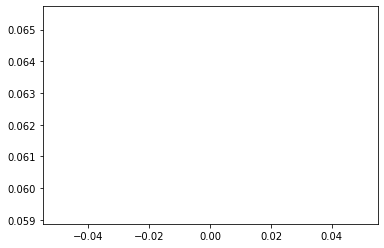

In [15]:
plot( tt, hm1 / l2 )

In [ ]:
plot( tt, linf / l2 )
#axis( xmin=0, xmax=20 )

In [ ]:
if saveframes:
    t_plots = linspace(0, T-dt, num=9)

    figsize( 12, 8 )
    for i in range(9):
        subplot( 3, 3, i+1)

        im=imshow( csave[int(t_plots[i]/dt), :], cmap=cm.jet)
        M = np.max( abs( csave[int(t_plots[i]/dt)] ) )
        im.set_clim( -M, M )
        title( 't = {:.3f}'.format(t_plots[i]))
        colorbar()

    subplots_adjust( wspace=.4 )
    figsize(4, 3)

In [ ]:
if saveframes:
    fig  = figure()
    im = imshow( csave[0, :], extent=[0, 1, 0, 1],
                interpolation='bilinear')
    fig.colorbar(im)
    tx = title('t={:.2f}'.format(0))
    fig.tight_layout()

    def animate(i):
        arr = csave[i, :] #/ sqrt(l2[i])
        im.set_array( arr )
        M = np.max( abs(arr) )
        im.set_clim( -M, M )
        tx.set_text( 't={:.2f}'.format( i*dt ))
    
        #return [im]

    ani = mpl.animation.FuncAnimation( fig, animate,
            frames=max_iters, interval=1000/25 )
    vid = ani.to_html5_video()

In [ ]:
if saveframes:
    HTML(vid)

In [ ]:
if savefigs:
    filename = 'figures/alt-shear-N={:02d}-A={:.3f}'.format(N, A)
    params = dict( N=N, dt=dt, nu=nu, T=T, A=A )
    savez_compressed( filename + '.npz',
          l2=l2, h1=h1, linf=linf, hm1=hm1, mean=mean, params=params )
    
    ani.save( filename + '.mp4')